# Importing libraries

In [1]:
import os
import re
import requests
import zipfile
import io
import codecs
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, GRU, LSTM, Bidirectional
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Download cornell movie-dialogs corpus dataset

In [2]:
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'
# download data
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
# unzip data, extract all the files
z.extractall()

# Data preprocessing

In [3]:
def get_all_conversations():
    all_conversations = []
    with codecs.open("./cornell movie-dialogs corpus/movie_lines.txt", 
                     "rb", 
                     encoding="utf-8", 
                     errors="ignore") as f:
        # split corpus by LF symbol
        lines = f.read().split("\n")
        for line in lines:
            # each line has multiple columns divided by '+++$+++'
            all_conversations.append(line.split(" +++$+++ "))
    return all_conversations[:5000]

def get_all_sorted_chats(all_conversations):
    all_chats = {}
    for tokens in all_conversations:
        # if the line is valid - it contains all the metadata
        if len(tokens) > 4:
            # save the line number and the text itself    
            all_chats[int(tokens[0][1:])] = tokens[4]
    # then sort the result and return list of tuples
    return sorted(all_chats.items(), key=lambda x: x[0])

def get_conversation_dict(sorted_chats):
    conv_dict = {}
    counter = 1
    conv_ids = []
    for i in range(1, len(sorted_chats) + 1):
        if i < len(sorted_chats):
        # if the current line number differs 
        # from the previous only by 1
            if (sorted_chats[i][0] - sorted_chats[i - 1][0]) == 1:
             # then this line is a part of the current conversation
             # if the previous line was not added before,
             # then we should add it now
                if sorted_chats[i - 1][1] not in conv_ids:
                    conv_ids.append(sorted_chats[i - 1][1])
                # or just append the current line
                conv_ids.append(sorted_chats[i][1])
            # and if the difference is more than 1 - it means new
            # conversation has started and we should clear conv_ids
            elif (sorted_chats[i][0] - sorted_chats[i - 1][0]) > 1:
                conv_dict[counter] = conv_ids
                conv_ids = []
            counter += 1
        else:
            continue
    return conv_dict

def clean_text(text_to_clean):
    text = text_to_clean.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

def get_clean_q_and_a(conversations_dictionary):
    ctx_and_target = []
    for current_conv in conversations_dictionary.values():
        # make sure that each conversation 
        # contains an even number of lines
        if len(current_conv) % 2 != 0:
            current_conv = current_conv[:-1]
        # convert questions and answers to the list of tuples
        for i in range(0, len(current_conv), 2):
            ctx_and_target.append((current_conv[i], 
                                   current_conv[i + 1]))
    # zip with * operator unzips tuples into independent lists
    context, target = zip(*ctx_and_target)
    context_dirty = list(context)
    # clear questions from contracted forms, non-letter symbols
    # and convert it to lowercase
    clean_questions = list()
    for i in range(len(context_dirty)):
        clean_questions.append(clean_text(context_dirty[i]))
    target_dirty = list(target)
    # do the same with the answers, but now we need
    # to add 'start' and 'end' words
    clean_answers = list()
    for i in range(len(target_dirty)):
        clean_answers.append('<START> ' 
                     + clean_text(target_dirty[i]) 
                     + ' <END>')
    return clean_questions, clean_answers

In [4]:
conversations = get_all_conversations()
print(f'Total conversations in dataset: {len(conversations)}')
all_sorted_chats = get_all_sorted_chats(conversations)
conversation_dictionary = get_conversation_dict(all_sorted_chats)
questions, answers = get_clean_q_and_a(conversation_dictionary)
print(f'Questions in dataset: {len(questions)}')
print(f'Answers in dataset: {len(answers)}')

Total conversations in dataset: 5000
Questions in dataset: 2347
Answers in dataset: 2347


In [5]:
target_regex = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789'
tokenizer = Tokenizer(filters=target_regex)
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 4998


In [6]:
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
# pad each question with zeros at the end
encoder_input_data = pad_sequences(tokenized_questions, 
                                 maxlen=maxlen_questions,
                                 padding='post')
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
# pad each answer with zeros at the end
decoder_input_data = pad_sequences(tokenized_answers,   
                                   maxlen=maxlen_answers,
                                   padding='post')

In [7]:
# remove the first 'start' word from every answer
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
# pad answers with zeros
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
# one-hot encoded each word using our vocabulary
decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE)

# Training & evaluating models

## 1. Unidirectional GRU

In [8]:
# create seq2seq unidirectional gru model
HIDDEN_DIM = 200
def build_uni_gru():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h = GRU(HIDDEN_DIM, return_state=True)(enc_embedding)
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_gru = GRU(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _ = dec_gru(dec_embedding, initial_state=state_h)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    # seq2seq
    uni_gru = Model([enc_inputs, dec_inputs], output)
    return uni_gru
# summary of the model
uni_gru = build_uni_gru()
uni_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
uni_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    999600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    999600      ['input_2[0][0]']                
                                                                                              


Current batch size: 8
Epoch 1/50
294/294 [==============================] - 22s 40ms/step - loss: 0.5194 - accuracy: 0.1665
Epoch 2/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4705 - accuracy: 0.2063
Epoch 3/50
294/294 [==============================] - 12s 39ms/step - loss: 0.4542 - accuracy: 0.2278
Epoch 4/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4425 - accuracy: 0.2399
Epoch 5/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4326 - accuracy: 0.2495
Epoch 6/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4229 - accuracy: 0.2564
Epoch 7/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4137 - accuracy: 0.2647
Epoch 8/50
294/294 [==============================] - 11s 39ms/step - loss: 0.4050 - accuracy: 0.2740
Epoch 9/50
294/294 [==============================] - 12s 39ms/step - loss: 0.3955 - accuracy: 0.2837
Epoch 10/50
294/294 [==============================] - 12s 

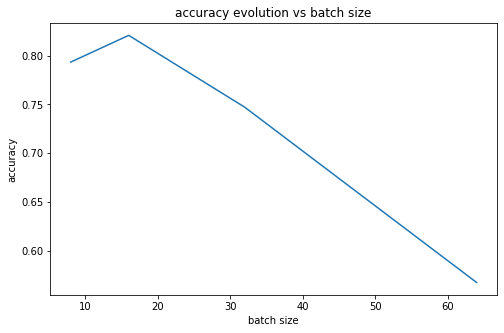

In [9]:
# training the model
EPOCHS = 50
uni_gru_all = []
uni_gru_acc = []
batch_sizes = [8, 16, 32, 64]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    uni_gru = build_uni_gru()
    uni_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = uni_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    uni_gru.save_weights(f'./uni_gru_{batch_size}.h5')
    acc = history.history.get('accuracy')
    uni_gru_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    uni_gru_acc.append(acc[-1])
print('\nTraining completed!\n')
# plot accuracy with diffrent batch sizes
plt.figure(figsize=(8, 5))
plt.title('accuracy evolution vs batch size')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.plot(batch_sizes, uni_gru_acc)
plt.show()

## 2. Bidirectional GRU

In [10]:
# create seq2seq bidirectional gru model
HIDDEN_DIM = 200
def build_bi_gru():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h = GRU(HIDDEN_DIM, return_state=True)(enc_embedding)
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_gru = GRU(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _ = dec_gru(dec_embedding, initial_state=state_h)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    # seq2seq
    bi_gru = Model([enc_inputs, dec_inputs], output)
    return bi_gru
# summary of the model
bi_gru = build_bi_gru()
bi_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
bi_gru.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, None, 200)    999600      ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, None, 200)    999600      ['input_12[0][0]']               
                                                                                            


Current batch size: 8
Epoch 1/50
294/294 [==============================] - 19s 42ms/step - loss: 0.5225 - accuracy: 0.1692
Epoch 2/50
294/294 [==============================] - 12s 43ms/step - loss: 0.4710 - accuracy: 0.2058
Epoch 3/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4543 - accuracy: 0.2263
Epoch 4/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4424 - accuracy: 0.2376
Epoch 5/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4326 - accuracy: 0.2480
Epoch 6/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4233 - accuracy: 0.2569
Epoch 7/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4140 - accuracy: 0.2662
Epoch 8/50
294/294 [==============================] - 12s 42ms/step - loss: 0.4049 - accuracy: 0.2724
Epoch 9/50
294/294 [==============================] - 12s 41ms/step - loss: 0.3958 - accuracy: 0.2841
Epoch 10/50
294/294 [==============================] - 12s 

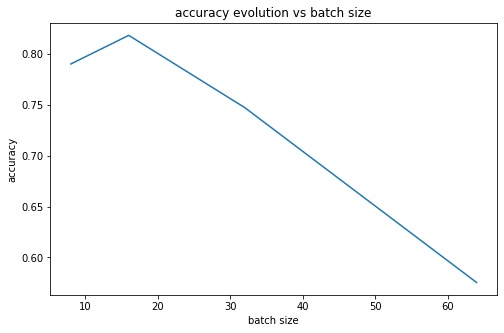

In [11]:
# training the model
EPOCHS = 50
bi_gru_all = []
bi_gru_acc = []
batch_sizes = [8, 16, 32, 64]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    bi_gru = build_bi_gru()
    bi_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = bi_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    bi_gru.save_weights(f'./bi_gru_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_gru_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_gru_acc.append(acc[-1])
print('\nTraining completed!\n')
# plot accuracy with diffrent batch sizes
plt.figure(figsize=(8, 5))
plt.title('accuracy evolution vs batch size')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.plot(batch_sizes, bi_gru_acc)
plt.show()

## 3. Unidirectional LSTM

In [12]:
# create seq2seq unidirectional lstm model
HIDDEN_DIM = 200
def build_uni_lstm():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h, state_c = LSTM(HIDDEN_DIM, return_state=True)(enc_embedding)
    enc_states = [state_h, state_c]
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    # seq2seq
    uni_lstm = Model([enc_inputs, dec_inputs], output)
    return uni_lstm
# summary of the model
uni_lstm = build_uni_lstm()
uni_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
uni_lstm.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, None, 200)    999600      ['input_21[0][0]']               
                                                                                                  
 embedding_21 (Embedding)       (None, None, 200)    999600      ['input_22[0][0]']               
                                                                                           


Current batch size: 8
Epoch 1/50
294/294 [==============================] - 19s 39ms/step - loss: 0.5306 - accuracy: 0.1507
Epoch 2/50
294/294 [==============================] - 12s 41ms/step - loss: 0.4853 - accuracy: 0.1851
Epoch 3/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4662 - accuracy: 0.2062
Epoch 4/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4526 - accuracy: 0.2241
Epoch 5/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4415 - accuracy: 0.2368
Epoch 6/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4318 - accuracy: 0.2457
Epoch 7/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4224 - accuracy: 0.2530
Epoch 8/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4133 - accuracy: 0.2622
Epoch 9/50
294/294 [==============================] - 12s 40ms/step - loss: 0.4036 - accuracy: 0.2717
Epoch 10/50
294/294 [==============================] - 12s 

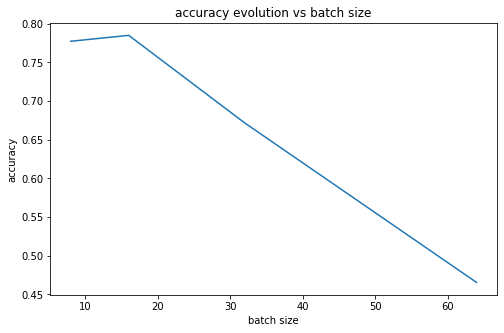

In [13]:
# training the model
EPOCHS = 50
uni_lstm_all = []
uni_lstm_acc = []
batch_sizes = [8, 16, 32, 64]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    uni_lstm = build_uni_lstm()
    uni_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = uni_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    uni_lstm.save_weights(f'./uni_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    uni_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    uni_lstm_acc.append(acc[-1])
print('\nTraining completed!\n')
# plot accuracy with diffrent batch sizes
plt.figure(figsize=(8, 5))
plt.title('accuracy evolution vs batch size')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.plot(batch_sizes, uni_lstm_acc)
plt.show()

## 3. Bidirectional LSTM

In [14]:
# create seq2seq bidirectional lstm model
HIDDEN_DIM = 200
def build_bi_lstm():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(HIDDEN_DIM, return_state=True))(enc_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    enc_states = [state_h, state_c]
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM * 2, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    bi_lstm = Model([enc_inputs, dec_inputs], output)
    return bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense
# summary of the model
model = build_bi_lstm()
bi_lstm = model[0]
bi_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
bi_lstm.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, None, 200)    999600      ['input_31[0][0]']               
                                                                                                  
 input_32 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 400),        641600      ['embedding_30[0][0]']           
                                 (None, 200),                                              


Current batch size: 8
Epoch 1/50
294/294 [==============================] - 23s 47ms/step - loss: 0.5243 - accuracy: 0.1607
Epoch 2/50
294/294 [==============================] - 15s 49ms/step - loss: 0.4785 - accuracy: 0.1955
Epoch 3/50
294/294 [==============================] - 14s 48ms/step - loss: 0.4597 - accuracy: 0.2178
Epoch 4/50
294/294 [==============================] - 14s 48ms/step - loss: 0.4462 - accuracy: 0.2323
Epoch 5/50
294/294 [==============================] - 14s 48ms/step - loss: 0.4343 - accuracy: 0.2437
Epoch 6/50
294/294 [==============================] - 14s 48ms/step - loss: 0.4226 - accuracy: 0.2543
Epoch 7/50
294/294 [==============================] - 14s 48ms/step - loss: 0.4096 - accuracy: 0.2663
Epoch 8/50
294/294 [==============================] - 14s 47ms/step - loss: 0.3956 - accuracy: 0.2792
Epoch 9/50
294/294 [==============================] - 14s 48ms/step - loss: 0.3814 - accuracy: 0.2952
Epoch 10/50
294/294 [==============================] - 14s 

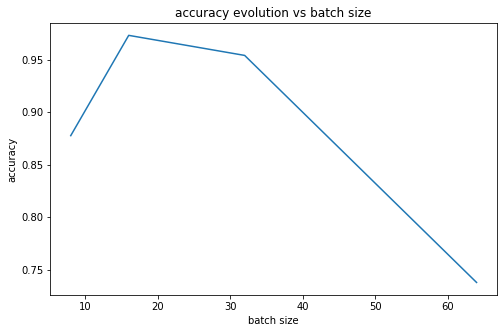

In [15]:
# training the model
EPOCHS = 50
bi_lstm_all = []
bi_lstm_acc = []
batch_sizes = [8, 16, 32, 64]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    model = build_bi_lstm()
    bi_lstm = model[0]
    bi_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = bi_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    bi_lstm.save_weights(f'./bi_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_lstm_acc.append(acc[-1])
print('\nTraining completed!\n')
# plot accuracy with diffrent batch sizes
plt.figure(figsize=(8, 5))
plt.title('accuracy evolution vs batch size')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.plot(batch_sizes, bi_lstm_acc)
plt.show()

# Comparison between models

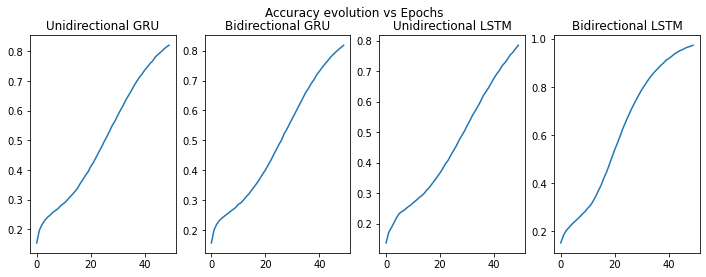

In [16]:
# plot the accuracy evolution for each model
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle('Accuracy evolution vs Epochs')
axs[0].set_title('Unidirectional GRU')
axs[0].plot(uni_gru_all[np.argmax(uni_gru_acc)])
axs[1].set_title('Bidirectional GRU')
axs[1].plot(bi_gru_all[np.argmax(bi_gru_acc)])
axs[2].set_title('Unidirectional LSTM')
axs[2].plot(uni_lstm_all[np.argmax(uni_lstm_acc)])
axs[3].set_title('Bidirectional LSTM')
axs[3].plot(bi_lstm_all[np.argmax(bi_lstm_acc)])
plt.show()

# Inference model

Now, it's time to interact with the chatbot, in this section we will create inferance model for the chatbot, I have choosed biderectional lstm since it is the most accurate one as we seen in the previous section

In [17]:
def make_inference_models():
  # load biderectional lstm model with the best batch size
    bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense = build_bi_lstm()
    batch_size = batch_sizes[np.argmax(bi_lstm_acc)]
    bi_lstm.load_weights(f'./bi_lstm_{batch_size}.h5')
    # decoder model
    dec_state_input_h = Input(shape=(HIDDEN_DIM * 2,))
    dec_state_input_c = Input(shape=(HIDDEN_DIM * 2,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                    initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
    # encoder model
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    return enc_model, dec_model

def str_to_tokens(sentence: str):
    # convert input string to lowercase, 
    # then split it by whitespaces
    words = sentence.lower().split()
    # and then convert to a sequence 
    # of integers padded with zeros
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')

In [ ]:
# create encoder/decoder models
encoder_model, decoder_model = make_inference_models()
# interact with the chatbot
while True:
    # encode the input sequence into state vectors
    input_text = input('You: ')
    if input_text == 'exit':
        break
    states_values = encoder_model.predict(str_to_tokens(input_text))
    # start with a target sequence of size 1 - word 'start'   
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        # feed the state vectors and 1-word target sequence 
        # to the decoder to produce predictions for the next word
        dec_outputs, h, c = decoder_model.predict([empty_target_seq]+states_values)         
        # sample the next word using these predictions
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        # append the sampled word to the target sequence
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        # repeat until we generate the end-of-sequence word 'end' 
        # or we hit the length of answer limit
        if sampled_word == 'end' \
                or len(decoded_translation.split()) \
                > maxlen_answers:
            stop_condition = True
        # prepare next iteration
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    print('Chatbot: '+decoded_translation)

You: whats about last night
Chatbot: you and the girl 
You: is the girl beautifuk
Chatbot: do you know how much i missed you 
You: i missed u so much
Chatbot: yeah 
You: thank you
Chatbot: want to try it again 
You: yes
Chatbot: that is all you got to say yes 
You: how can i say that
Chatbot: you know what i have got that i am real my know 
You: how are you
Chatbot: i am not really 
You: hi harshika
Chatbot: does it get any better or what 
You: harshika is so cute
Chatbot: the get out of get for the job back to know he will you told you all well they are not going but i will give you a little one 
You: she is really cute
Chatbot: is not for you 
